# Installations that cause frequent errors on TPU

In [1]:
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


# Set Environment

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import matplotlib.pyplot as plt
import pandas as pd

import pickle
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import gc

D0827 15:55:18.654289140    4162 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0827 15:55:18.654316332    4162 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0827 15:55:18.654320436    4162 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0827 15:55:18.654323726    4162 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0827 15:55:18.654326943    4162 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0827 15:55:18.654330134    4162 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0827 15:55:18.654333194    4162 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0827 15:55:18.

TensorFlow version: 2.12.0


# Set Seed for Reproducibility

In [3]:
def set_seed(seed=21019):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Loading data splits and one-hot encoding

In [4]:
print('Loaing data ...')
with open('/kaggle/input/data-split-additional-v2-noaug/data_splits_additional_v2_no_aug.pkl', 'rb') as f:
    loaded_splits = pickle.load(f)

x_train = loaded_splits['x_train']
x_val = loaded_splits['x_val']
x_test = loaded_splits['x_test']
y_train = loaded_splits['y_train']
y_val = loaded_splits['y_val']
y_test = loaded_splits['y_test']

y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

print(f'Samples in Train Set: {len(y_train_encoded)}')
print(f'Samples in Validation Set: {len(y_val_encoded)}')
print(f'Samples in Test Set: {len(y_test_encoded)}')

Loaing data ...
Samples in Train Set: 6844
Samples in Validation Set: 1712
Samples in Test Set: 2139


# Pretrained Model + New Classifier Layer

**With TPU Enabled**

In [5]:
# Define class names
class_names = list(['Type 1','Type 2','Type 3'])

# Define the input shape
input_shape = x_train[0].shape

# Pretrained base
pretrained_base = tf.keras.applications.resnet_v2.ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
pretrained_base.trainable = False

# New classification layer
x = pretrained_base.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(len(class_names), activation='softmax')(x)

# Create the model
model = Model(inputs=pretrained_base.input, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary of the model
model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 233, 233, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 114, 114, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

# Train Model

In [6]:
# Remove garbage to free up memory
print(f'Freeing up memory!')
gc.collect()

# Define the learning rate scheduler function
def lr_scheduler(epoch, lr):
    new_lr = lr * 0.01 if epoch % 5 == 0 else lr
    return new_lr

# Create the LearningRateScheduler callback
lr_callback = LearningRateScheduler(lr_scheduler)

# Train the model with history tapping (keeps data in a dictionary)
epochs = 25
batch_size = 128
history = model.fit(x_train, y_train_encoded, 
                    validation_data=(x_val,y_val_encoded),
                    epochs=epochs, 
                    batch_size=batch_size,
                    callbacks=[lr_callback],
                    shuffle=True)

Freeing up memory!
Epoch 1/25
54/54 [==============================] - 139s 3s/step - loss: 36.1114 - accuracy: 0.3635 - val_loss: 22.8068 - val_accuracy: 0.4060 - lr: 1.0000e-06
Epoch 2/25
54/54 [==============================] - 133s 2s/step - loss: 18.4460 - accuracy: 0.4261 - val_loss: 17.7424 - val_accuracy: 0.4147 - lr: 1.0000e-06
Epoch 3/25
54/54 [==============================] - 136s 3s/step - loss: 14.9278 - accuracy: 0.4538 - val_loss: 15.4224 - val_accuracy: 0.4276 - lr: 1.0000e-06
Epoch 4/25
54/54 [==============================] - 136s 3s/step - loss: 12.3389 - accuracy: 0.4760 - val_loss: 13.4659 - val_accuracy: 0.4468 - lr: 1.0000e-06
Epoch 5/25
54/54 [==============================] - 139s 3s/step - loss: 10.4167 - accuracy: 0.5069 - val_loss: 12.2817 - val_accuracy: 0.4848 - lr: 1.0000e-06
Epoch 6/25
54/54 [==============================] - 139s 3s/step - loss: 9.2422 - accuracy: 0.5431 - val_loss: 11.8860 - val_accuracy: 0.4749 - lr: 1.0000e-08
Epoch 7/25
54/54 [====

# Evaluate Model

In [7]:
# Remove garbage to free up memory
print(f'Freeing up memory!')
gc.collect()

loss, accuracy = model.evaluate(x_test, y_test_encoded)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

Freeing up memory!
67/67 [==============================] - 31s 460ms/step - loss: 11.4540 - accuracy: 0.4904
Test loss: 11.4540
Test accuracy: 0.4904


# Classification Report

In [8]:
# Get the true labels and predicted probabilities for the test data
# Make predictions on new images
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Generate the classification report
report = classification_report(y_test, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

67/67 [==============================] - 33s 472ms/step
Classification Report:
               precision    recall  f1-score   support

      Type 1       0.55      0.51      0.53       735
      Type 2       0.43      0.45      0.44       725
      Type 3       0.49      0.51      0.50       679

    accuracy                           0.49      2139
   macro avg       0.49      0.49      0.49      2139
weighted avg       0.49      0.49      0.49      2139



# Confusion Matrix

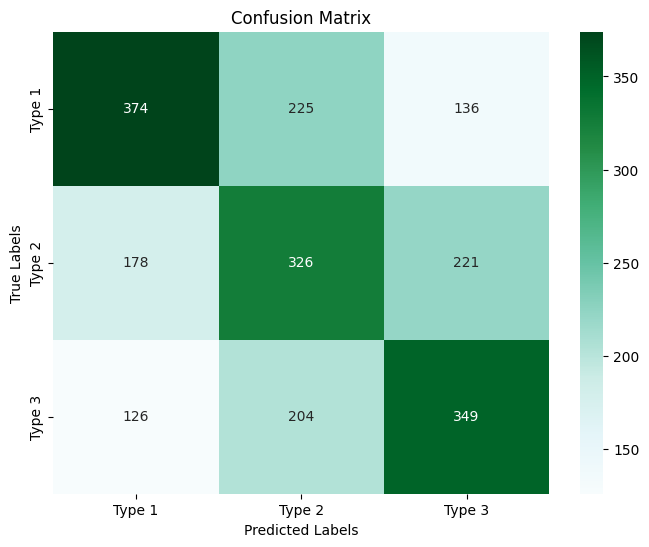

In [9]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Taining Curves

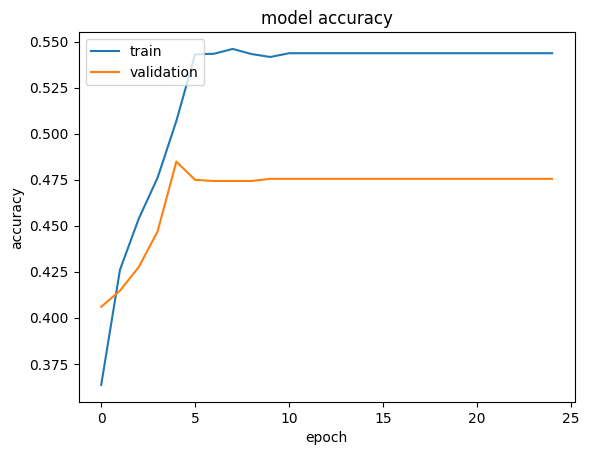

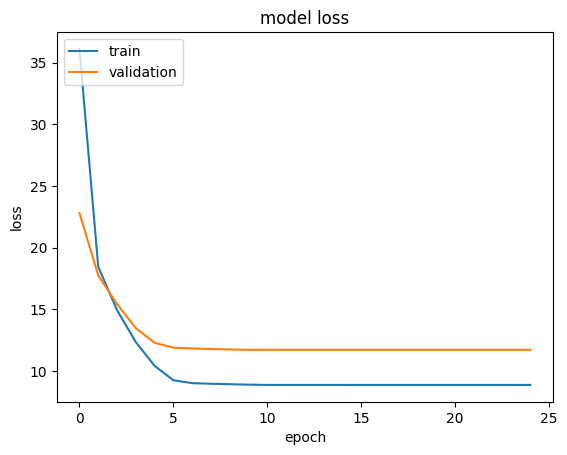

In [10]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()